N: 1, hl_exp: 0.23971276930210145, sql_exp: 0.2397127693021015
N: 2, hl_exp: 0.4708759887798252, sql_exp: 0.479425538604203
N: 3, hl_exp: 0.7042600132496014, sql_exp: 0.7191383079063045
N: 4, hl_exp: 0.938601326127437, sql_exp: 0.9588510772084059
N: 5, hl_exp: 1.1735121306193133, sql_exp: 1.1985638465105075
N: 6, hl_exp: 1.4088133770597642, sql_exp: 1.4382766158126092
N: 7, hl_exp: 1.6444049115882053, sql_exp: 1.677989385114711
N: 8, hl_exp: 1.8802239202851052, sql_exp: 1.9177021544168114
N: 9, hl_exp: 2.116227873548353, sql_exp: 2.157414923718914
N: 10, hl_exp: 2.3523863489248513, sql_exp: 2.397127693021014
N: 11, hl_exp: 2.588676664429869, sql_exp: 2.636840462323116
N: 12, hl_exp: 2.825081353400982, sql_exp: 2.8765532316252185
N: 13, hl_exp: 3.0615866117430084, sql_exp: 3.116266000927321
N: 14, hl_exp: 3.2981812952409904, sql_exp: 3.3559787702294193
N: 15, hl_exp: 3.5348562457093298, sql_exp: 3.5956915395315248
N: 16, hl_exp: 3.7716038228410844, sql_exp: 3.835404308833625
N: 17, hl_e

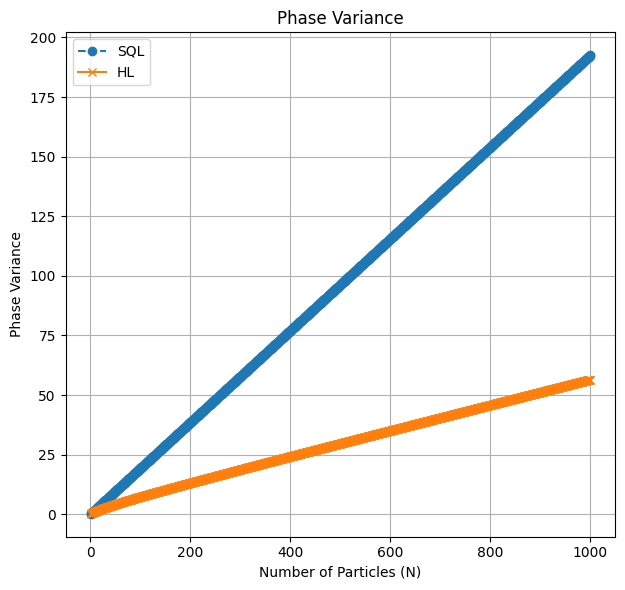

(500, 500, 1001) (1001,)
(500, 500, 1001) (1001,)
(500, 500, 1001) (1001,)
(500, 500, 1001) (1001,)
(500, 500, 1001) (1001,)


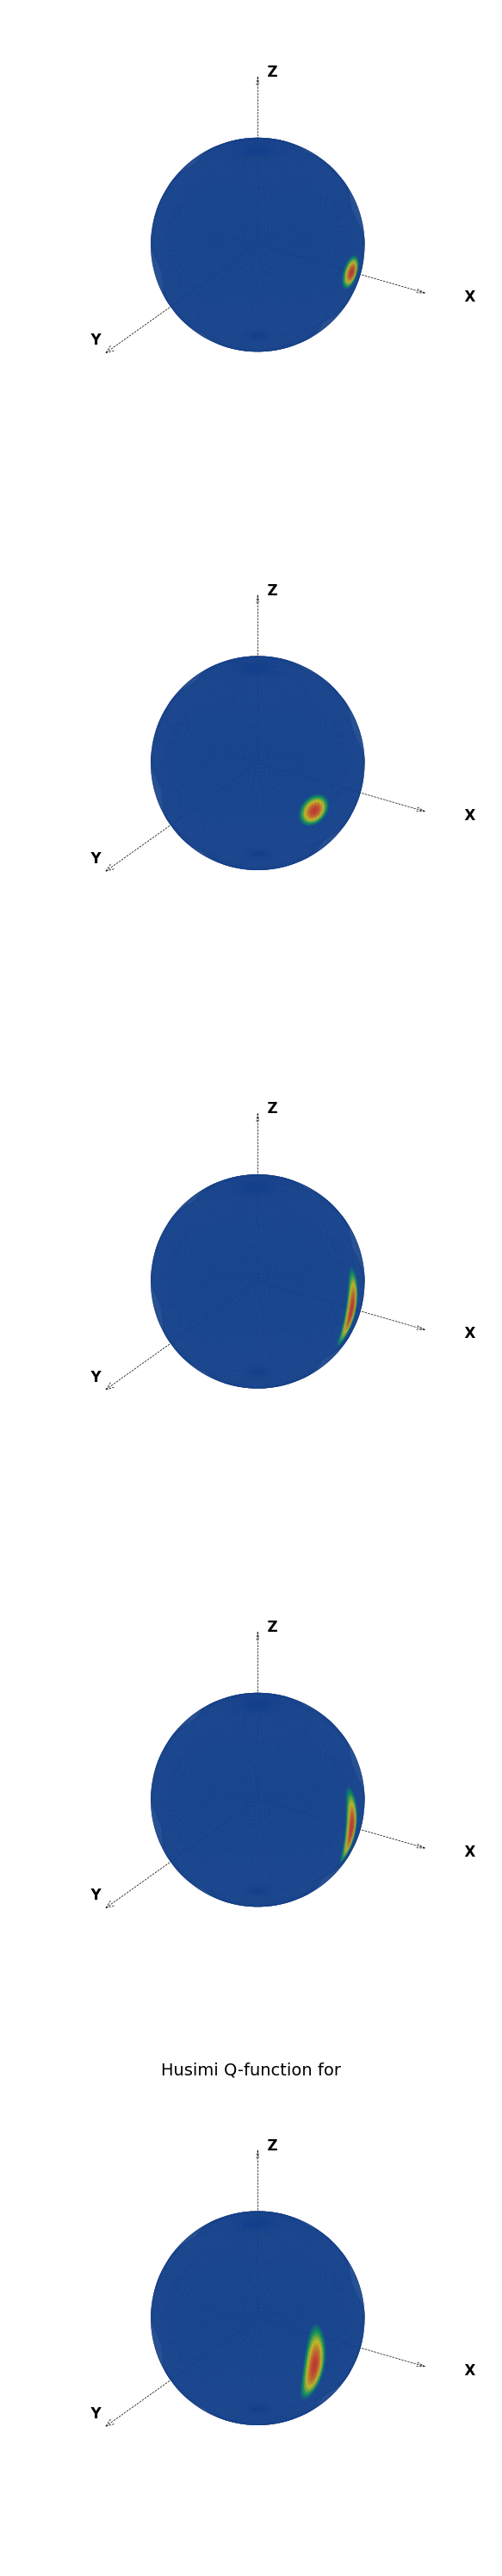

In [2]:
import numpy as np
import qutip as qt
from quantum_metrology.config import N_MAX, OMEGA, TAU_SENSE
from quantum_metrology.utils.husimi import plot_all
from quantum_metrology.utils.metrology import calculate_phase_variances
from quantum_metrology.utils.plotting import plot_results


# H = omega * tau * Jz
def qobj_to_coeffs(qobj: qt.Qobj) -> np.ndarray:
    if not qobj.isket:                       # the routine only handles pure kets
        raise TypeError("state must be a ket Qobj")
    vec = qobj.full().ravel()                # dense NumPy array (order +J … −J)
    return vec[::-1]                         # reverse → −J … +J


def main():
    # Calculate phase variances and metrological gain
    phase_var_sql, phase_var_hl, final_states = calculate_phase_variances(
        N_MAX, OMEGA, TAU_SENSE)
    
    plot_results(N_MAX, phase_var_sql, phase_var_hl)
    # for state in final_states:

    plot_all(N_MAX/2, final_states)


if __name__ == "__main__":
    main()

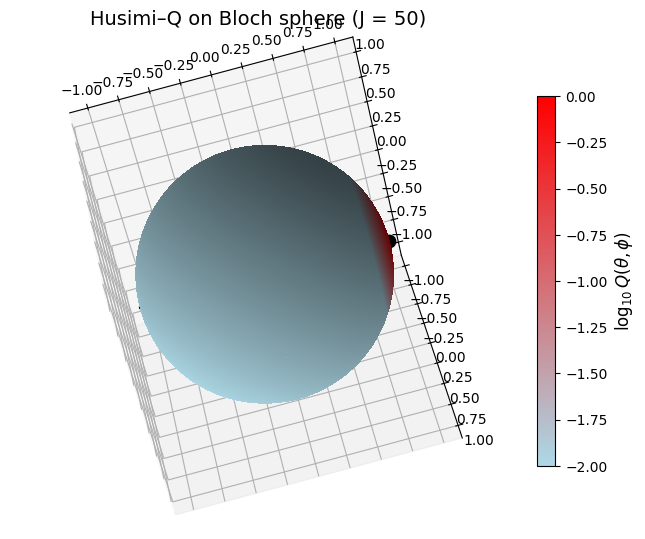

In [ ]:
# -------------------------------------------------------------
# Husimi-Q plot on a Bloch sphere – spin-J coherent state
# Axes:  x = sinθ·cosφ , y = sinθ·sinφ , z = cosθ  (standard)
# Peak (hottest): (1,0,0)
# Darkest colour : light-blue   →   Hottest colour : red
# -------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 — activates 3-D support

# ---------- USER PARAMETERS ----------
J       = 50            # Spin quantum number
n_theta = 500            # Polar resolution
n_phi   = 1000           # Azimuthal resolution

theta0  = np.pi/2        # Peak direction
phi0    = 0.0            # Peak at (1,0,0) with standard axes
# -------------------------------------

# Grid
theta = np.linspace(0, np.pi, n_theta)
phi   = np.linspace(0, 2*np.pi, n_phi)
TH, PH = np.meshgrid(theta, phi)

# Husimi-Q
cosT2   = np.cos(TH/2)
sinT2   = np.sin(TH/2)
cosT02  = np.cos(theta0/2)
sinT02  = np.sin(theta0/2)
overlap = cosT2*cosT02 + sinT2*sinT02*np.exp(-1j*(PH - phi0))
Q       = np.abs(overlap)**(2*J)
Q      /= Q.max()
Qlog    = np.log10(Q + np.finfo(float).eps)

# Colour-scale limits
cmin = Qlog.max() - 2
cmax = Qlog.max()

# Custom colormap: light-blue ➜ red
light_blue = np.array([0.678, 0.847, 0.902])
red        = np.array([1.0,   0.0,   0.0  ])
ncol = 256
cmap = np.vstack([ np.linspace(light_blue[i], red[i], ncol) for i in range(3) ]).T
my_cmap = cm.colors.ListedColormap(cmap)

# Cartesian coordinates
X = np.sin(TH)*np.cos(PH)
Y = np.sin(TH)*np.sin(PH)
Z = np.cos(TH)

# Coherent-state point
x0 = np.sin(theta0)*np.cos(phi0)
y0 = np.sin(theta0)*np.sin(phi0)
z0 = np.cos(theta0)               # 0 for theta0 = π/2

# Plot
fig = plt.figure(figsize=(8,8), facecolor='w')
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1,1,1])

# Bloch sphere shell
u,v = np.mgrid[0:2*np.pi:100j, 0:np.pi:100j]
XS = np.cos(u)*np.sin(v)
YS = np.sin(u)*np.sin(v)
ZS = np.cos(v)
ax.plot_surface(XS,YS,ZS, color=[0.9,0.9,0.9], alpha=0.1, linewidth=0)

# Husimi-Q surface
surf = ax.plot_surface(X, Y, Z, facecolors=my_cmap((Qlog-cmin)/(cmax-cmin)),
                       rstride=1, cstride=1, linewidth=0, antialiased=False)

# Peak marker
ax.scatter(x0, y0, z0, s=80, c='k')

# Plot the 3D axes centered on the Bloch sphere
ax.plot([-1, 1], [0, 0], [0, 0], color='black', lw=2)  # X-axis
ax.plot([0, 0], [-1, 1], [0, 0], color='black', lw=2)  # Y-axis
ax.plot([0, 0], [0, 0], [-1, 1], color='black', lw=2)  # Z-axis

# Colour bar
mappable = cm.ScalarMappable(cmap=my_cmap)
mappable.set_array([])
mappable.set_clim(cmin, cmax)
cb = plt.colorbar(mappable, shrink=0.6, pad=0.05, ax=ax)
cb.set_label(r'$\log_{10} Q(\theta,\phi)$', fontsize=12)

# Aesthetics
ax.view_init(elev=130, azim=270, roll=15)
ax.set_axis_off()
plt.title(f'Husimi–Q on Bloch sphere (J = {J})', fontsize=14)
plt.show()


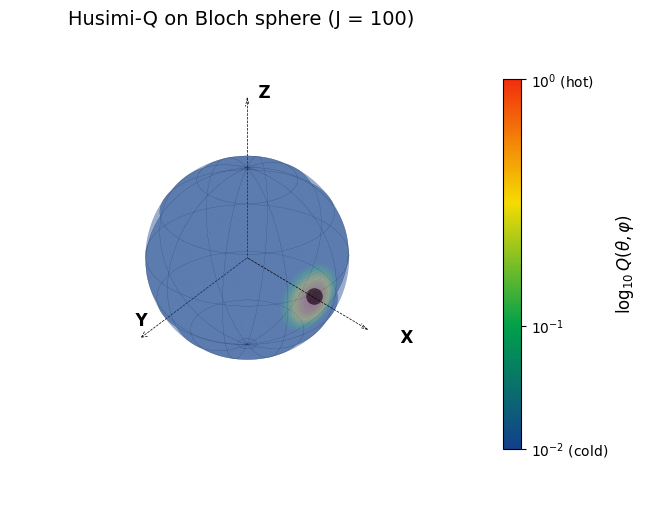

In [12]:
#!/usr/bin/env python3
# --------------------------------------------------------------
#  Husimi-Q plot on a Bloch sphere – general spin-J state
#
#  •  Call plot_husimi_bloch(state, J) where `state` is a length-(2J+1)
#     complex array of ⟨J,m|ψ⟩ components ordered for m = −J…J.
#  •  The figure shows the Q-function on the sphere plus coloured
#     laboratory axes  X (red), Y (green) and Z (blue).
# --------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.special import binom
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (keeps the 3-D backend)


def plot_husimi_bloch(state,
                       J: int,
                       n_theta: int = 100,
                       n_phi: int = 200,
                       *,
                       q_alpha: float = 1,
                       show_peak: bool = True,
                       show_axes: bool = True,
                       title: str | None = None):
    """
    Display the Husimi-Q function of a spin-J state on the Bloch sphere.

    Parameters
    ----------
    state : ndarray, shape (2*J+1,)
        Components ⟨J,m|ψ⟩ in the J_z basis for m = −J…J.
        Will be auto-normalised if needed.
    J : int
        Total spin quantum number.
    n_theta, n_phi : int
        Grid resolutions for polar θ and azimuthal φ.
    show_peak : bool
        Mark the point where Q is maximal.
    show_axes : bool
        Draw reference X, Y, Z arrows.
    title : str or None
        Custom figure title (defaults to 'Husimi-Q …').
    """
    # ---- sanity checks -------------------------------------------------
    state = np.asarray(state, dtype=np.complex128).ravel()
    if state.size != 2 * J + 1:
        raise ValueError(f"state length {state.size} ≠ 2J+1 = {2*J+1}")
    if not np.isclose(state.conj() @ state, 1.0):
        state = state / np.linalg.norm(state)

    # ---- combinatorial prefactors √C(2J, J+m) --------------------------
    m_vals = np.arange(-J, J + 1)
    binom_sqrt = np.sqrt(binom(2 * J, J + m_vals))     # shape (2J+1,)

    # ---- θ-φ grids -----------------------------------------------------
    theta = np.linspace(0, np.pi, n_theta)
    phi = np.linspace(0, 2 * np.pi, n_phi)
    TH, PH = np.meshgrid(theta, phi, indexing='ij')     # (n_theta, n_phi)

    # ---- coefficients c_m(θ,φ) ----------------------------------------
    cos_th2 = np.cos(TH / 2)[..., None]                 # add m-axis
    sin_th2 = np.sin(TH / 2)[..., None]

    exponent_cos = J + m_vals
    exponent_sin = J - m_vals
    phase = np.exp(-1j * m_vals * PH[..., None])        # e^{−i m φ}

    coeffs = (binom_sqrt
              * cos_th2**exponent_cos
              * sin_th2**exponent_sin
              * phase)                                 # (..., 2J+1)

    # ---- overlap ⟨θ,φ|ψ⟩ and Q-function -------------------------------
    overlap = np.tensordot(coeffs, state.conj(), axes=(2, 0))
    Q = np.abs(overlap)**2
    Q /= Q.max()

    # ---- logarithmic colour scale (top two decades) --------------------
    Qlog = np.log10(Q + np.finfo(float).eps)
    cmax, cmin = 0, -3

    navy   = (0.07, 0.25, 0.55)           # sphere colour  (R,G,B)
    green  = (0.00, 0.63, 0.29)
    yellow = (0.96, 0.86, 0.01)
    red    = (0.95, 0.18, 0.05)

    cmap = LinearSegmentedColormap.from_list(
        "blue_hot", [navy, green, yellow, red], N=256)


    # ---- θ,φ → Cartesian with x↔y swap ---------------------------------
    X = np.sin(TH) * np.sin(PH)
    Y = np.sin(TH) * np.cos(PH)
    Z = np.cos(TH)

    # ---- figure --------------------------------------------------------
    fig = plt.figure(figsize=(8, 6), facecolor='w')
    ax = fig.add_subplot(111, projection='3d')
    ax.patch.set_facecolor('white')

    # transparent Bloch sphere shell
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    xs = np.outer(np.cos(u), np.sin(v))
    ys = np.outer(np.sin(u), np.sin(v))
    zs = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_surface(xs, ys, zs,
                    facecolor=navy, edgecolor='k',
                    cstride=16,
                    linewidth=0.05, alpha=0.25)

    # Husimi-Q surface
    normed = (Qlog - cmin) / (cmax - cmin)
    fc = cmap(normed)
    # fc[..., -1] *= q_alpha
    ax.plot_surface(X, Y, Z,
                    facecolors=fc,
                    rcount=n_theta, ccount=n_phi,
                    #rstride=1, cstride=1,
                    antialiased=True, linewidth=0, zorder=2,
                    alpha=0.25, shade=False 
                    )


    # mark the peak
    if show_peak:
        idx_max = np.unravel_index(Q.argmax(), Q.shape)
        th_max, ph_max = TH[idx_max], PH[idx_max]
        x0 = np.sin(th_max) * np.sin(ph_max)
        y0 = np.sin(th_max) * np.cos(ph_max)
        z0 = np.cos(th_max)
        ax.scatter(x0, y0, z0, s=120, color='k', depthshade=False, zorder=3)

    # reference axes (quiver arrows)
    b = 'black'
    if show_axes:
        axis_len = [1.75, 1.75, 1.75]
        linestyles = ['dashed', 'dashed', 'dashed']
        quiv_opts = [dict(length=axis_len[i],
                       arrow_length_ratio=0.05,
                       linewidth=0.5,
                       linestyle= linestyles[i],
                       normalize=False) for i in range(len(axis_len))]
        ax.quiver(0, 0, 0, 0, 1, 0, color=b, **quiv_opts[0])   # X
        ax.quiver(0, 0, 0, 0, -1, -1, color=b, **quiv_opts[1], label="Y")   # Y
        ax.quiver(0, 0, 0, 0, 0, 1, color=b, **quiv_opts[2])   # Z
        ax.text(0, axis_len[0]+0.3, 0,  "  X", color=b, fontsize=12, weight='bold')
        ax.text(0, -axis_len[1]-0.3, -axis_len[1],  "  Y", color=b, fontsize=12, weight='bold')
        ax.text(0, 0, axis_len[2], "  Z", color=b, fontsize=12, weight='bold')

    # # colour bar
    mappable = plt.cm.ScalarMappable(cmap=cmap)
    mappable.set_clim(cmin, cmax)
    cb = fig.colorbar(mappable, shrink=0.8, pad=0.05, ax=ax)
    cb.set_ticks([cmin, cmin+1, cmax])
    cb.set_ticklabels([r'$10^{-2}$ (cold)',
                   r'$10^{-1}$',
                   r'$10^{0}$ (hot)'])
    cb.set_label(r"$\log_{10} Q(\theta,\varphi)$", fontsize=12)

    # viewpoint and limits
    ax.view_init(elev=30, azim=50)
    rng = 1.35
    ax.set_xlim([-rng, rng])
    ax.set_ylim([-rng, rng])
    ax.set_zlim([-rng, rng])
    try:                           # Matplotlib ≥3.3
        ax.set_box_aspect((1, 1, 1))
    except AttributeError:
        pass
    ax.set_axis_off()

    # title
    ax.set_title(title or f"Husimi-Q on Bloch sphere (J = {J})", fontsize=14)

    return fig, ax


# ----------------------------------------------------------------------
# Example: coherent state along +X  (θ = π/2, φ = 0) for J = 10
# ----------------------------------------------------------------------
if __name__ == "__main__":
    J_example = 100
    m = np.arange(-J_example, J_example + 1)
    coeff = np.sqrt(binom(2 * J_example, J_example + m))
    psi_coh = coeff * (np.cos(np.pi / 4))**(J_example + m) * (np.sin(np.pi / 4))**(J_example - m)
    plot_husimi_bloch(psi_coh, J_example)
    plt.show()


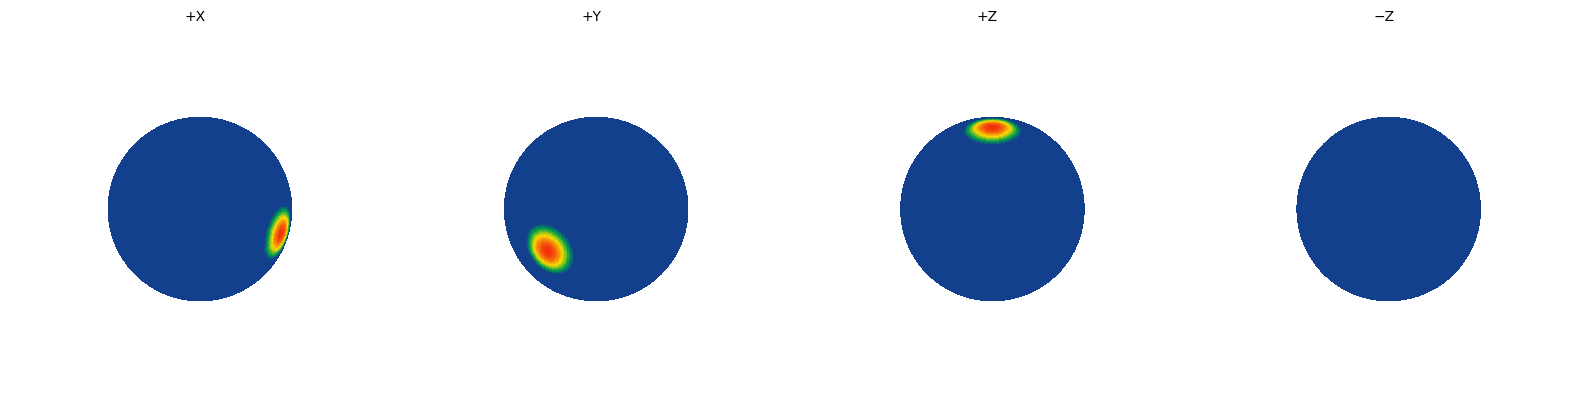

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d.axes3d import Axes3D  # type: ignore
from dataclasses import dataclass
from typing import Sequence, Tuple


# ---------- utility: build spin-coherent state coefficients in Jz basis ----------
def spin_coherent_np(J: int, theta: float, phi: float) -> np.ndarray:
    """
    Return NumPy array of ⟨J,m|θ,φ⟩ coefficients for m = -J..+J (ascending m).
    """
    m = np.arange(-J, J + 1)
    # binomial prefactor
    from scipy.special import binom
    binom_sqrt = np.sqrt(binom(2 * J, J + m))
    # coherent amplitudes
    cth = np.cos(theta / 2.0)
    sth = np.sin(theta / 2.0)
    amps = (binom_sqrt *
            (cth ** (J + m)) *
            (sth ** (J - m)) *
            np.exp(-1j * m * phi))
    # normalisation (should already be 1)
    amps = amps / np.linalg.norm(amps)
    return amps.astype(np.complex128)


# ---------- colour map used in examples ----------
NAVY   = (0.07, 0.25, 0.55)
GREEN  = (0.00, 0.63, 0.29)
YELLOW = (0.96, 0.86, 0.01)
RED    = (0.95, 0.18, 0.05)
CMAP = LinearSegmentedColormap.from_list("blue_hot", [NAVY, GREEN, YELLOW, RED], N=256)


# ---------- compute Husimi surface data ----------
@dataclass
class SurfaceData:
    X: np.ndarray
    Y: np.ndarray
    Z: np.ndarray
    facecolors: np.ndarray


def get_husimi_surface_np(state: np.ndarray, J: int,
                          n_theta: int = 200, n_phi: int = 400,
                          q_alpha: float = 1.0,
                          log_min: float = -2.0) -> SurfaceData:
    """
    state: NumPy vector, m=-J..+J order
    """
    state = np.asarray(state, dtype=np.complex128).ravel()
    if state.size != 2 * J + 1:
        raise ValueError("bad length")
    if not np.isclose(np.linalg.norm(state), 1.0):
        state = state / np.linalg.norm(state)

    from scipy.special import binom
    m_vals = np.arange(-J, J + 1)
    binom_sqrt = np.sqrt(binom(2 * J, J + m_vals))

    theta = np.linspace(0.0, np.pi, n_theta)
    phi = np.linspace(0.0, 2.0 * np.pi, n_phi, endpoint=False)
    TH, PH = np.meshgrid(theta, phi, indexing="ij")

    cos_th2 = np.cos(TH / 2.0)[..., None]
    sin_th2 = np.sin(TH / 2.0)[..., None]
    phase = np.exp(-1j * m_vals * PH[..., None])

    coeffs = (binom_sqrt *
              cos_th2 ** (J + m_vals) *
              sin_th2 ** (J - m_vals) *
              phase)

    overlap = np.tensordot(coeffs, state.conj(), axes=(2, 0))
    Q = np.abs(overlap) ** 2
    Q /= Q.max()

    Qlog = np.log10(Q + np.finfo(float).eps)
    Qlog = np.clip(Qlog, log_min, 0.0)
    norm = (Qlog - log_min) / (-log_min)

    fc = CMAP(norm)
    fc[..., -1] = q_alpha

    X = np.sin(TH) * np.sin(PH)
    Y = np.sin(TH) * np.cos(PH)
    Z = np.cos(TH)

    return SurfaceData(X, Y, Z, fc)


# ---------- multi-panel plot ----------
def plot_surface_grid(surfaces: Sequence[SurfaceData],
                      titles: Sequence[str] | None = None,
                      n_cols: int | None = None,
                      figsize: Tuple[float, float] = (12, 8)) -> plt.Figure:
    import math
    N = len(surfaces)
    if N == 0:
        raise ValueError("no surfaces")
    if titles is None:
        titles = [f"State {i+1}" for i in range(N)]
    if n_cols is None:
        n_cols = math.ceil(math.sqrt(N))
    n_rows = math.ceil(N / n_cols)

    fig = plt.figure(figsize=figsize, facecolor="w")

    # sphere mesh (reused)
    u = np.linspace(0.0, 2.0 * np.pi, 80)
    v = np.linspace(0.0, np.pi, 40)
    xs = np.outer(np.cos(u), np.sin(v))
    ys = np.outer(np.sin(u), np.sin(v))
    zs = np.outer(np.ones_like(u), np.cos(v))

    for i, surf in enumerate(surfaces):
        ax: Axes3D = fig.add_subplot(n_rows, n_cols, i + 1, projection="3d")
        # sphere shell
        ax.plot_surface(xs, ys, zs,
                        facecolor=NAVY, edgecolor='k',
                        linewidth=0.2, alpha=0.25,
                        rstride=4, cstride=4)
        # husimi
        ax.plot_surface(surf.X, surf.Y, surf.Z,
                        facecolors=surf.facecolors,
                        rstride=1, cstride=1, linewidth=0,
                        antialiased=False, shade=False)
        ax.set_box_aspect((1, 1, 1))
        rng = 1.2
        ax.set_xlim([-rng, rng]); ax.set_ylim([-rng, rng]); ax.set_zlim([-rng, rng])
        ax.set_axis_off()
        ax.view_init(elev=30, azim=30)
        ax.set_title(titles[i], fontsize=10)

    fig.tight_layout()
    return fig


# ---------- generate example surfaces ----------
J = 100
states = [
    spin_coherent_np(J, np.pi/2, 0.0),          # +X
    spin_coherent_np(J, np.pi/2, np.pi/2),      # +Y
    spin_coherent_np(J, 0.0, 0.0),              # +Z
    spin_coherent_np(J, np.pi, 0.0),            # -Z
]

surfaces = [get_husimi_surface_np(s, J, q_alpha=1.0, log_min=-2.0)
            for s in states]

fig = plot_surface_grid(surfaces,
                        titles=["+X", "+Y", "+Z", "−Z"],
                        n_cols=4,
                        figsize=(16, 4))

plt.show()
